In [1]:

import cv2
import math
import csv
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from ultralytics.solutions.solutions import BaseSolution
from ultralytics.utils.plotting import Annotator, colors
from datetime import datetime
%matplotlib inline

https://www.digitalocean.com/community/tutorials/what-is-new-with-yolo

## EJERCICIO 10
Vamos a hacer fine tuning sobre el modelo para segmentación SAM-2.

Puedes sacar información de la siguiente página:

https://blog.roboflow.com/fine-tune-sam-2-1/

A la hora de conseguir el dataset, descargalo para no tener problemas con la API-KEY de Roboflow

In [2]:
!git clone https://github.com/facebookresearch/sam2.git sam2Main
!wget -O /content/sam2/sam2/configs/train.yaml 'https://drive.usercontent.google.com/download?id=11cmbxPPsYqFyWq87tmLgBAQ6OZgEhPG3'


Clonando en 'sam2Main'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Recibiendo objetos: 100% (1070/1070), 134.70 MiB | 14.62 MiB/s, listo.
Resolviendo deltas: 100% (375/375), listo.
/content/sam2/sam2/configs/train.yaml: No existe el archivo o el directorio


In [3]:
%cd ./sam2Main/
%pip install -e .[dev]
%pip install supervision -q
!cd ./checkpoints && ./download_ckpts.sh

/home/iabd/Escritorio/IABD/IA/SAPA/Redes Neuronales/sam2Main
Obtaining file:///home/iabd/Escritorio/IABD/IA/SAPA/Redes%20Neuronales/sam2Main
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13837 sha256=cf9cdd33a4aadf7890f9cc75b49b27b9ddb299d02bc8968cfbc06f7cada5a47c
  Stored in directory: /tmp/pip-ephem-wheel-cache-00pocch6/wheels/68/4d/ff/c6a01d1a397a37b835973948c3ed1b9b2b19cd7404ad2dfc2a
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
-

In [4]:
import os
import re

FOLDER = "/home/iabd/Descargas/Car Parts.v6i.sam2/train"

for filename in os.listdir(FOLDER):
    new_filename = filename.replace(".", "_", filename.count(".") - 1)
    if not re.search(r"_\d+\.\w+$", new_filename):
        new_filename = new_filename.replace(".", "_1.")
    os.rename(os.path.join(FOLDER, filename), os.path.join(FOLDER, new_filename))
    

In [6]:

!python training/train.py -c 'configs/train.yaml' --use-cluster 0 --num-gpus 1

###################### Train App Config ####################
scratch:
  resolution: 1024
  train_batch_size: 1
  num_train_workers: 10
  num_frames: 1
  max_num_objects: 3
  base_lr: 5.0e-06
  vision_lr: 3.0e-06
  phases_per_epoch: 1
  num_epochs: 40
dataset:
  img_folder: /home/iabd/Descargas/Car Parts.v6i.sam2/train
  gt_folder: /home/iabd/Descargas/Car Parts.v6i.sam2/train
  multiplier: 2
vos:
  train_transforms:
  - _target_: training.dataset.transforms.ComposeAPI
    transforms:
    - _target_: training.dataset.transforms.RandomHorizontalFlip
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomAffine
      degrees: 25
      shear: 20
      image_interpolation: bilinear
      consistent_transform: true
    - _target_: training.dataset.transforms.RandomResizeAPI
      sizes: ${scratch.resolution}
      square: true
      consistent_transform: true
    - _target_: training.dataset.transforms.ColorJitter
      consistent_transform: true
      brightness:

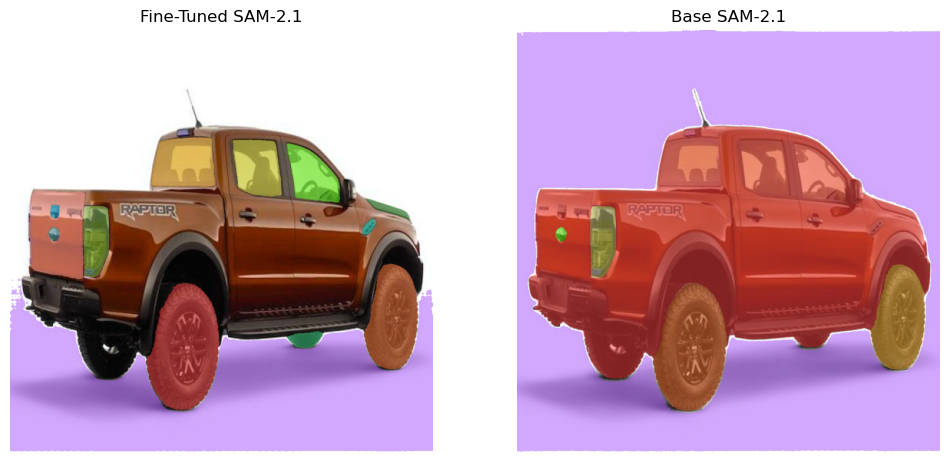

In [13]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import supervision as sv
import os
import random
from PIL import Image
import numpy as np

# use bfloat16 for the entire notebook
# from Meta notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

checkpoint = "/home/iabd/Escritorio/IABD/IA/SAPA/Redes Neuronales/sam2Main/sam2_logs/configs/train.yaml/checkpoints/checkpoint.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device="cuda")
mask_generator = SAM2AutomaticMaskGenerator(sam2)

checkpoint_base = "/home/iabd/Escritorio/IABD/IA/SAPA/Redes Neuronales/sam2Main/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg_base = "configs/sam2.1/sam2.1_hiera_b+.yaml"
sam2_base = build_sam2(model_cfg_base, checkpoint_base, device="cuda")
mask_generator_base = SAM2AutomaticMaskGenerator(sam2_base)


validation_set = os.listdir("/home/iabd/Descargas/Car Parts.v6i.sam2/valid")

# choose random with .json extension
image = random.choice([img for img in validation_set if img.endswith(".jpg")])
image = os.path.join("/home/iabd/Descargas/Car Parts.v6i.sam2/valid", image)
opened_image = np.array(Image.open(image).convert("RGB"))
result = mask_generator.generate(opened_image)

detections = sv.Detections.from_sam(sam_result=result)

mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
annotated_image = opened_image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)

base_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

base_result = mask_generator_base.generate(opened_image)
base_detections = sv.Detections.from_sam(sam_result=base_result)
base_annotated_image = opened_image.copy()
base_annotated_image = base_annotator.annotate(base_annotated_image, detections=base_detections)

sv.plot_images_grid(images=[annotated_image, base_annotated_image], titles=["Fine-Tuned SAM-2.1", "Base SAM-2.1"], grid_size=(1, 2))